## train model in parallel to different scans (i.e. different input sequences over clips)

In [38]:
# ! Load General Modules
%matplotlib inline
#notebook
import matplotlib
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from visualization import visualize
#import seaborn as sns
import scipy.stats as sps
from scipy.stats import chi
import scipy as sp
from scipy import signal
import scipy.io as sio
from sklearn import linear_model
import pickle
import datetime
import time
import os
import pickle
import datajoint as dj
from matplotlib.backends.backend_pdf import PdfPages
#dj.conn()
%load_ext autoreload
%autoreload 2

# Tensorflow needs to be LAST import
import tensorflow as tf
print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.5.0


## Get Data

In [6]:
#! load data
[X_nm_test,X_nm_train,Y_nm_test,Y_train_ordered,Y_train,
            num_roi,observation_noise,
           depths,ordering,sequences] = np.load('NM_data_pilot2.npy')

### add pilot 1 data?

In [4]:
# pilot1
[_,_,Y_nm_test_1,Y_nm_train_1,_,_,num_roi_1,observation_noise_1] = np.load('NM_data.npy')

Y_nm_test=np.concatenate([Y_nm_test,Y_nm_test_1],0)
num_roi = np.concatenate([num_roi,num_roi_1])
observation_noise = np.concatenate([observation_noise,observation_noise_1])

#ordering of training random sequence
file = open('./data/pilot1/IndexSequences.txt', 'r') 
ordering_1 = list(map(int, file.read().splitlines()))
file.close()

#! order responses
Y_train_ordered_1 = np.zeros_like(Y_nm_train_1)
tmp_ind=0
for s in range(len(num_roi_1)):
    for i in range(108):
        ind = ordering_1[i]
        Y_train_ordered_1[tmp_ind:tmp_ind+num_roi_1[s],ind*150:(ind+1)*150] = Y_nm_train_1[
                        tmp_ind:tmp_ind+num_roi_1[s],i*150:(i+1)*150]
    tmp_ind+=num_roi_1[s]
Y_train_ordered=np.concatenate([Y_train_ordered,Y_train_ordered_1],0)
Y_train = np.concatenate([Y_train,Y_nm_train_1],0)

print(num_roi,'Rois',Y_train_ordered.shape,'Train',Y_nm_test.shape,'Test',len(observation_noise),'noise')

[83 98 84 57 65 51 34 23] Rois (495, 16200) Train (495, 750) Test 495 noise


In [7]:
#! global variables
steps_hist=25
N,D_test = Y_nm_test.shape
S=len(num_roi)
D_train,stim_x,stim_y = X_nm_train.shape

In [8]:
#! load sta_inits
STA = np.load('staNM_pilot2.npy')

In [9]:
#! pick val set (random SEEDED! because sequences are mixed anyway)
np.random.seed(seed=1234)
num_val = 10#like test
D_val=num_val*150
D_train-=D_val
num_test = 5
num_train = 108-num_val
val_ind = np.random.choice(108,num_val,replace=False)
train_ind = []
for i in range(108):
    if not(i in val_ind):
        train_ind.append(i)
val_ind=np.sort(val_ind)
print('validation clips indices ',val_ind)

validation clips indices  [33 40 42 52 57 59 62 64 81 82]


In [10]:
#! select inputs per scan around val set, one list per scan, one list per sequence for training
X_test_orig = X_nm_test
Y_test_orig = []
X_train_orig = []
Y_train_orig = []
X_val_orig = np.zeros((num_val,150,stim_x,stim_y))
print('train and test are with cuts, validation only within clips')
for i in range(num_val):
    X_val_orig[i] = X_nm_train[val_ind[i]*150:(val_ind[i]+1)*150]
Y_val_orig = []
roi=0
for s in range(S):
    Y_test_orig.append(Y_nm_test[roi:roi+num_roi[s]])#per scan
    Y_val_orig.append(np.zeros([num_roi[s],150-steps_hist+1,num_val]))#per scan, NDB
    for i in range(num_val):
        Y_val_orig[s][:,:,i] = Y_train_ordered[roi:roi+num_roi[s],
                                   val_ind[i]*150+steps_hist-1:(val_ind[i]+1)*150]
        
    indices=[[]]#indices for train sequences, interrupted by val, for this scan
    num_ind=0
    X_train_orig.append([])#for this scan
    Y_train_orig.append([])#for this scan
    
    tmp_x=[]#temporary sequence as list of clips
    tmp_y=[]#tmp responses
    
    for c in range(108):#over clips in this scan
        if s<5:
            ind=ordering[c,sequences[s]]#current clip index
        else:
            ind=ordering_1[c]
        if np.in1d(ind,val_ind):#if clip is in validation set
            num_ind+=len(indices[-1])
            indices.append([])
            if indices[-2]:#if previous is not empty
                X_train_orig[s].append(np.concatenate(tmp_x,0))
                Y_train_orig[s].append(np.concatenate(tmp_y,1))
                tmp_x=[]#temporary sequence as list of clips
                tmp_y=[]#tmp responses
        else:
            indices[-1].append(ind)
            tmp_x.append(X_nm_train[ind*150:(ind+1)*150])
            tmp_y.append(Y_train[roi:roi+num_roi[s],c*150:(c+1)*150])
            
    #last one
    if indices[-1]:#if previous is not empty
        X_train_orig[s].append(np.concatenate(tmp_x,0))
        Y_train_orig[s].append(np.concatenate(tmp_y,1))
    num_ind+=len(indices[-1])
    #print(num_ind,'\n',len(indices),'\n',indices)
    roi+=num_roi[s]
print('test',X_test_orig.shape,len(Y_test_orig),Y_test_orig[0].shape)
print('train',len(X_train_orig),len(X_train_orig[0]),X_train_orig[0][0].shape,
              len(Y_train_orig),len(Y_train_orig[0]),Y_train_orig[0][0].shape,
      '\n they are not all same length, if e.g. two val clips are in a row in some sequence')
print('val',X_val_orig.shape,len(Y_val_orig),Y_val_orig[0].shape)

train and test are with cuts, validation only within clips
test (750, 64, 64) 5 (83, 750)
train 5 11 (750, 64, 64) 5 11 (83, 750) 
 they are not all same length, if e.g. two val clips are in a row in some sequence
val (10, 150, 64, 64) 5 (83, 126, 10)


In [11]:
#! val and test set in right shapes
X_test = []
X_val = []
Y_test = []
#list of: NDB format (is already)
Y_val = Y_val_orig
for s in range(S):
    #identical list of: BDHWC format
    X_test.append(np.reshape(X_test_orig,[1,750,stim_x,stim_y,1]))
    X_val.append(np.reshape(X_val_orig,[num_val,150,stim_x,stim_y,1]))
    #list of: NDB format
    Y_test.append(np.expand_dims(Y_test_orig[s][:,steps_hist-1:],axis=2))
    
print('test',len(X_test),X_test[0].shape,len(Y_test),Y_test[0].shape)
print('val',len(X_val),X_val[0].shape,len(Y_val),Y_val[0].shape)

test 5 (1, 750, 64, 64, 1) 5 (83, 726, 1)
val 5 (10, 150, 64, 64, 1) 5 (83, 126, 10)


In [12]:
# ! prepare inputs
def prepare_inputs(chunk_size=50,
                   batch_chunks=10,
                   steps_hist=25,
                   shift=0):#shift maximally=chunk_size
    
    X_train=[]
    Y_train=[]
    for s in range(S):#across scans
        tmp_x=[]#list of all train chunks for this scan
        tmp_y=[]#list of all responses for this scan
        for seq in range(len(X_train_orig[s])):
            #how many chunks fit in here?
            num_chunks = X_train_orig[s][seq].shape[0]//chunk_size
            if shift:#one less to make space for shift
                num_chunks -= 1
            #draw chunks
            tmp_ind=shift
            for c in range(num_chunks):
                tmp_x.append(X_train_orig[s][seq][tmp_ind:tmp_ind+chunk_size])
                tmp_y.append(Y_train_orig[s][seq][:,tmp_ind:tmp_ind+chunk_size])
                tmp_ind+=chunk_size
        num_chunks = len(tmp_x)#how many chunks in total?
        num_batch = num_chunks//batch_chunks
        rand_ind = np.random.choice(num_chunks,num_chunks,replace=False)
        
        #list of BBDHWC format (cycle through these)
        X_train.append(np.zeros([num_batch,batch_chunks,chunk_size,stim_x,stim_y,1]))
        #list of BNDB format (cycle through these)
        Y_train.append(np.zeros([num_batch,num_roi[s],chunk_size-steps_hist+1,batch_chunks]))
        
        tmp_ind=0#chunks
        for i in range(num_batch):
            for j in range(batch_chunks):
                X_train[s][i,j] = np.expand_dims(tmp_x[rand_ind[tmp_ind]],axis=3)
                Y_train[s][i,:,:,j] = tmp_y[rand_ind[tmp_ind]][:,steps_hist-1:]
                tmp_ind += 1
       
    if shift:
        num_batch -= 1
    #change format to list(batches) of list(scans) in BDHWC and NDB
    tmp_x=[]
    tmp_y=[]
    for b in range(num_batch):
        tmp_x.append([])
        tmp_y.append([])
        for s in range(S):
            tmp_x[b].append(X_train[s][b])
            tmp_y[b].append(Y_train[s][b])
    X_train=tmp_x
    Y_train=tmp_y


    #print('training',X_train.shape,Y_train.shape)
    #print('val',X_val.shape,Y_val.shape)
    #print('test',X_test.shape,Y_test.shape)
    
    return X_train,Y_train

In [22]:
X_train,Y_train = prepare_inputs()
print(len(X_train),len(X_train[0]),len(Y_train),len(Y_train[0]))
for s in range(S):
    print(X_train[0][s].shape,Y_train[0][s].shape)

29
29
29
29
29
29
29
29
8 8 29
29 8 29 8
(10, 50, 64, 64, 1) (83, 26, 10)
(10, 50, 64, 64, 1) (98, 26, 10)
(10, 50, 64, 64, 1) (84, 26, 10)
(10, 50, 64, 64, 1) (57, 26, 10)
(10, 50, 64, 64, 1) (65, 26, 10)
(10, 50, 64, 64, 1) (51, 26, 10)
(10, 50, 64, 64, 1) (34, 26, 10)
(10, 50, 64, 64, 1) (23, 26, 10)


In [13]:
#! real names of ON types
type_names = ['5t','5o','5i','X','6','7','8','9','RBC']

In [14]:
#! stack test set
Y_test_split = []
X_test_split = []
for s in range(S):
    Y_test_split.append([])
    X_test_split.append([])
    for c in range(5):
        Y_test_split[-1].append(Y_test[s][:,c*150:c*150+126])
        X_test_split[-1].append(X_test[s][:,c*150:(c+1)*150])
    Y_test_split[-1] = np.concatenate(Y_test_split[-1],2)
    X_test_split[-1] = np.concatenate(X_test_split[-1],0)

In [15]:
#! Parameters
steps_hist=25
ks = np.array([[18,1,1],[1,30,30],[8,8,8]])#kernel sizes per layer: DHW - depth, height, width
num_feat = [4,8,16]
#resulting mask size:
mask_x = stim_x
mask_y = stim_y
for i in range(ks.shape[0]):
    mask_x -= ks[i,1]-1
    mask_y -= ks[i,2]-1

batch_chunks=2
X_train,Y_train=prepare_inputs(chunk_size=50,batch_chunks=batch_chunks,steps_hist=25,shift=0)

signal_noise = []
for s in range(S):
    signal_noise.append(np.var(Y_test[s],1).flatten())
signal_noise = np.concatenate(signal_noise)

init_lr=.0001

# make sta init
tmp_init = np.random.normal(0,.05,[mask_x,mask_y,N])
tmp_indx = (stim_x-mask_x)//2
tmp_indy = (stim_y-mask_y)//2

for i in range(N):
    crop = abs(STA[i,tmp_indx:tmp_indx+mask_x,tmp_indy:tmp_indy+mask_y])
    max_ind = np.unravel_index(np.argmax(crop),[mask_x,mask_y])
    tmp_init[max_ind[0],max_ind[1],i] = .5
sta_init = []
ind=0
for s in range(S):
    sta_init.append(tmp_init[:,:,ind:ind+num_roi[s]])
    ind+=num_roi[s]

# Model (from old9)

In [16]:
directory='DVS_normal/'

In [17]:
#! first session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [18]:
#TF MODEL:
#close previous session
sess.close()
#clean checkpoints
files = os.listdir('./running/'+directory)
for file in files:
    if file.startswith("runn"):
        os.remove('./running/'+directory+file)
    if file.startswith("0train"):
        os.remove('./running/'+directory+file)
        
#saving text output to log file
with open('running/'+directory+'running.txt', "w") as log:
    print('# TF MODEL (on Natural Movie Data) \n', file=log)
    
    

graph = tf.Graph()#new tf graph
with graph.as_default():#use it as default
    
    #Batch Normalization - see below, channels last: NHWC for BN
    model_istrain = tf.placeholder(tf.bool)
    model_X=[]
    model_Y=[]
    model_Y_=[]
    model_kernels=[]
    model_masks=[]
    model_weights=[]
    model_MSE_neuron=[]
    model_MSE, model_reg_mask, model_reg_weights = 0, 0, 0
    
    for s in range(S):#i, x in enumerate(inputs_per_scan):
        with tf.variable_scope('net', reuse=(s > 0)):

            #input tensor of shape BDHWC - (batches, depth, height, width, channels)
            model_X.append(tf.placeholder(tf.float32,shape=[None,None,stim_x,stim_y,1]))
            #output: neurons x depth x batch
            model_Y.append(tf.placeholder(tf.float32,shape=[num_roi[s],None,None]))

            #Conv layer 1
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            #model_kernels = []
            kernels = tf.get_variable(name='kernels1',
                                      shape=[ks[0,0],ks[0,1],ks[0,2],1,num_feat[0]],
                                      initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv1 = tf.nn.conv3d(model_X[-1],
                                    model_kernels[0],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv1 = tf.contrib.layers.batch_norm(model_conv1, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv1 = tf.nn.relu(model_conv1)

            #Conv layer 2
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels2',
                                            shape=[ks[1,0],ks[1,1],ks[1,2],num_feat[0],num_feat[1]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv2 = tf.nn.conv3d(model_conv1,
                                    model_kernels[1],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv2 = tf.contrib.layers.batch_norm(model_conv2, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv2 = tf.nn.relu(model_conv2)

            #Conv layer 3
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels3',
                                            shape=[ks[2,0],ks[2,1],ks[2,2],num_feat[1],num_feat[2]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv3 = tf.nn.conv3d(model_conv2,
                                    model_kernels[2],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv3 = tf.contrib.layers.batch_norm(model_conv3, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            #model_conv3 = tf.nn.relu(model_conv3)

            #shape now: BDHWC
            model_conv_out = tf.transpose(model_conv3,perm=[0,1,4,2,3])
            #shape now: BDCHW

            ## RF layers

        with tf.variable_scope('net', reuse=False):
            #mask: HWN
            model_masks.append(tf.get_variable(
                            name='masks{}'.format(s),
                            shape=sta_init[s].shape,
                            initializer=tf.constant_initializer(sta_init[s])))
            model_masks[-1] = tf.abs(model_masks[-1]) / (
                1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_masks[-1]),[0,1],keep_dims=True)))

            model_masked = tf.einsum('bdchw,hwn->bdcn',
                                 model_conv_out,
                                 model_masks[-1])#batch x depth x features x neurons
            
            #weighing
            model_weights_init = np.random.normal(1/num_feat[-1],.01,[num_feat[-1],num_roi[s]])
            model_weights.append(tf.get_variable(name='weights{}'.format(s),
                                            shape=[num_feat[-1],num_roi[s]],
                                            initializer=tf.constant_initializer(model_weights_init)))
            model_weights_a = tf.abs(model_weights[-1])# / (
            #    1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_weights), 0, keep_dims=True))))
            model_Y_.append(tf.transpose(tf.einsum('bdcn,cn->bdn',
                                 model_masked,
                                 model_weights_a),perm=[2,1,0]))

            model_MSE_neuron.append(tf.reduce_mean(tf.square(model_Y_[-1]-model_Y[-1]), [1, 2]))
            model_MSE += tf.reduce_sum(model_MSE_neuron[-1])

            model_reg_mask += .1 * tf.reduce_sum(tf.abs(model_masks[-1]))
            model_reg_weights += .001 * tf.reduce_sum(model_weights_a,1)
    
    #extra reg
    _,dum = tf.nn.moments(model_kernels[0]/(1e-8+tf.sqrt(tf.reduce_sum(
                    tf.square(model_kernels[0]),[0],keep_dims=True))),axes=[0])
    time_reg = .01*tf.reduce_sum(dum)
    #laplace smoothness
    W=tf.squeeze(model_kernels[1])#HWIO
    lap = tf.constant([[0.25, 0.5, 0.25], [0.5, -3.0, 0.5], [0.25, 0.5, 0.25]])
    lap = tf.expand_dims(tf.expand_dims(lap, 2), 3)
    out_channels = W.get_shape().as_list()[2]
    W_lap = tf.nn.depthwise_conv2d(tf.transpose(W, perm=[3, 0, 1, 2]),
                                   tf.tile(lap, [1, 1, out_channels, 1]),
                                   strides=[1, 1, 1, 1], padding='SAME')
    penalty = tf.reduce_sum(tf.reduce_sum(tf.square(W_lap), [1, 2]) / (
        tf.transpose(tf.reduce_sum(tf.square(W), [0, 1]))))
    penalty1 = tf.identity(.0001 * penalty, name='penalty')
    #group sparsity
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(W), [0, 1])))
    penalty2 = tf.identity(.001 * penalty, name='penalty')
    #3rd layer
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(model_kernels[2]), [0,1,2])))
    penalty3 = tf.identity(.001 * penalty, name='penalty')
    
    #Loss
    model_loss = model_MSE + model_reg_mask + model_reg_weights + penalty1 + penalty2 + penalty3 + time_reg
    
    #training ops
    model_lr = tf.placeholder(tf.float32)
    model_training = tf.train.AdamOptimizer(model_lr).minimize(model_loss)
    #BN
    model_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    #Train
    #with tf.Session() as sess:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    tmp_train=[]
    tmp_val=[]
    tmp_run=[]
    tmp_losses=[[],[],[],[],[],[],[]]#mse,mask,weight,time,group1,group2,laplace
    tmp_mean_fev=[]
    j = 0#batch counter

    feed_val = {model_istrain: False,
                model_lr: init_lr}
    feed_test = {model_istrain: False,
                 model_lr: init_lr}
    for s in range(S):
        feed_val.update({model_X[s]: X_val[s]})
        feed_val.update({model_Y[s]: Y_val[s]})
        feed_test.update({model_X[s]: X_test[s]})
        feed_test.update({model_Y[s]: Y_test[s]})

    #for plotting:
    cmap = plt.cm.get_cmap('hsv')
    colors = np.vstack([cmap(np.arange(1,6)/30),cmap(np.arange(1,10)/15+.3)])

    #saving text output to log file
    with open('running/'+directory+'running.txt', "w") as log:
        print('# TF MODEL (on Natural Movie Data) \n', file=log)
        
    #early stoppig
    stop_a=0
    stop_b=0
    lr=init_lr

    for i in range(10000):
        feed={model_istrain: True,
              model_lr: lr}
        for s in range(S):
            feed.update({model_X[s]: X_train[j][s]})
            feed.update({model_Y[s]: Y_train[j][s]})
        j += 1
        if j==len(X_train):
            shift = np.random.randint(0,50)

            X_train,Y_train=prepare_inputs(chunk_size=50,
                                                   batch_chunks=batch_chunks,
                                                   steps_hist=steps_hist,
                                                   shift=shift)
            j = 0#batch counter
        
        #often
        if not(i%50):
            tmp_run.append(i)
            tmp_Y_ = []
            weights = [] 
            masks = []
            MSE = np.zeros(N)
            ind=0
            for s in range(S):
                tmp_Y_.append(model_Y_[s].eval(feed_val,session=sess))
                weights.append(model_weights[s].eval(session=sess))
                masks.append(model_masks[s].eval(session=sess))
                MSE[ind:ind+num_roi[s]] = model_MSE_neuron[s].eval(feed_test,session=sess)
                ind+=num_roi[s]
                
            weights = np.concatenate(weights,1)
            masks = np.concatenate(masks,2)
            
            tmp_train.append(model_MSE.eval(feed,session=sess))
            tmp_val.append(model_MSE.eval(feed_val,session=sess))

            #not shown
            tmp_losses[0].append(tmp_train[-1])
            tmp_losses[1].append(model_reg_mask.eval(feed,session=sess))
            tmp_losses[2].append(model_reg_weights.eval(feed,session=sess))
            tmp_losses[3].append(time_reg.eval(feed,session=sess))
            tmp_losses[4].append(penalty2.eval(feed,session=sess))
            tmp_losses[5].append(penalty3.eval(feed,session=sess))
            tmp_losses[6].append(penalty1.eval(feed,session=sess))

            FEV= 1-(MSE.flatten()-observation_noise)/(signal_noise-observation_noise)
            tmp_mean_fev.append(np.mean(FEV))

            tmp_time=model_kernels[0].eval(session=sess)

            tmp_space=model_kernels[1].eval(session=sess)

            tmp_kernel2 = model_kernels[2].eval(session=sess)
            
            
            with open('running/'+directory+'running.txt', "a") as log:
                print('RUN = %s, MSE: train=%s, val=%s'%(
                    tmp_run[-1],tmp_train[-1],tmp_val[-1]), file=log)
            
            #Plotting!
            visualize(tmp_run,save=True,show=False,folder=directory,
                      mse=[tmp_train,tmp_val],
                      weights=[weights,num_roi,[True,True],num_roi],
                      pred_true=[np.concatenate(Y_val,0),np.concatenate(tmp_Y_,0)],
                      losses=[tmp_losses,['mse','mask','weight','time','group1','group2','laplace']],
                      mask=[masks],
                      fev=[FEV,tmp_mean_fev,num_roi],
                      time=[tmp_time],
                      space=[tmp_space],
                      kernel2=[tmp_kernel2])
            
            #early stopping?
            if tmp_val[-1]>np.min(tmp_val):#worse than best?
                stop_a += 1
                if stop_a==10:# times in a row worse
                    stop_b += 1
                    stop_a = 0
                    lr *= .9#lower lr
                    with open('running/'+directory+'running.txt', "a") as log:
                        print('LR=%s'%(lr), file=log)
                    if stop_b==5:#lower lr x times
                        break
            else:
                stop_a=0

        sess.run([model_training,model_update_ops],feed)
#sess.close()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Model DVS

In [20]:
directory='DVS_dvs/'

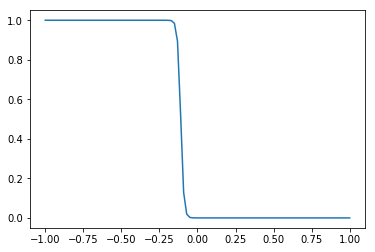

In [47]:
plt.plot(np.linspace(-1,1,100),sp.special.expit(1e2*(-np.linspace(-1,1,100)-.11)))

<IPython.core.display.Javascript object>


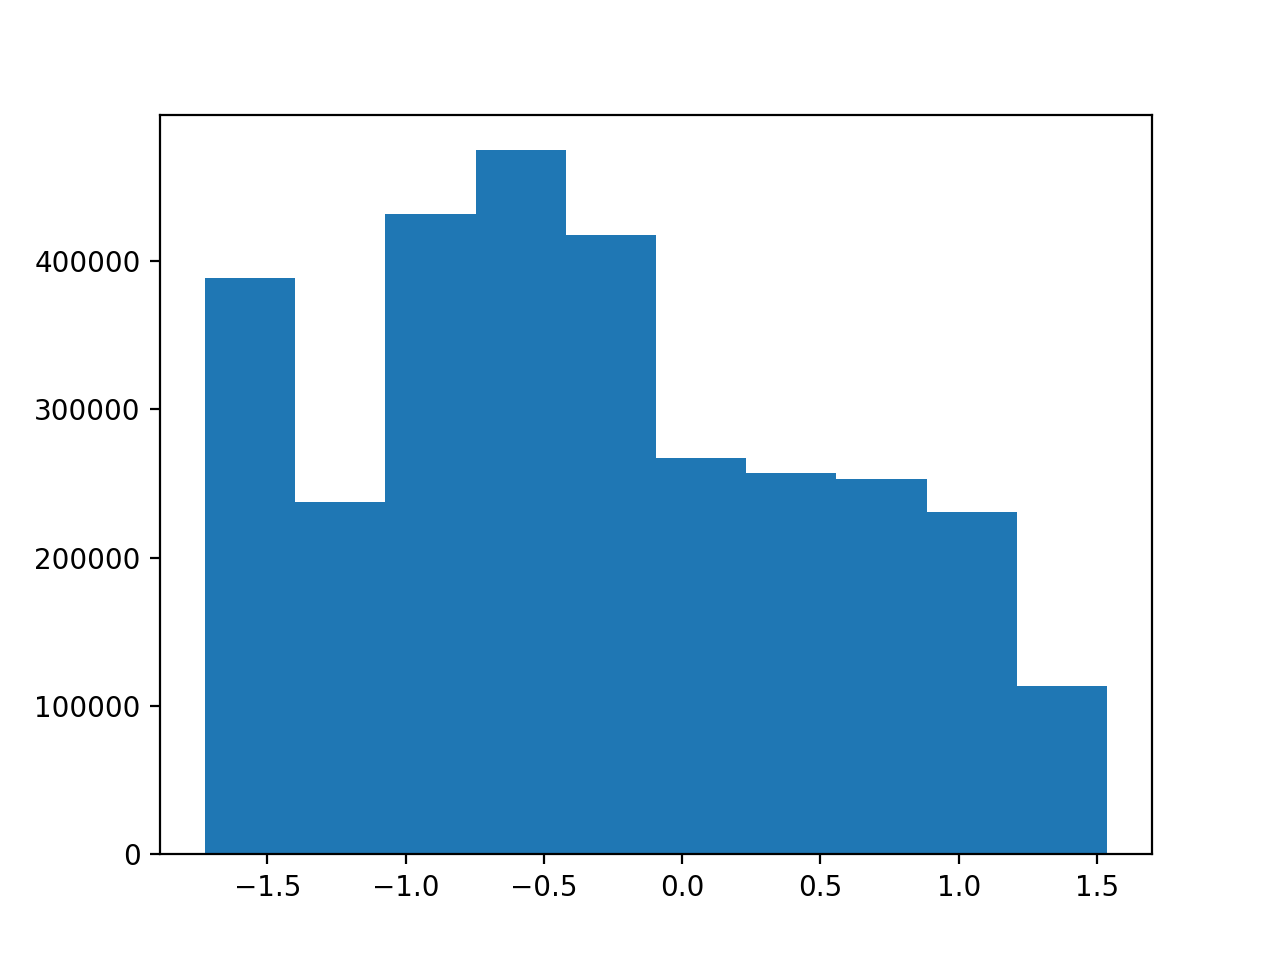

(array([388560., 237423., 431819., 474575., 417493., 267250., 257359.,
        252879., 230935., 113707.]),
 array([-1.72529815, -1.39918297, -1.07306779, -0.74695261, -0.42083743,
        -0.09472225,  0.23139293,  0.55750811,  0.88362329,  1.20973847,
         1.53585364]),
 <a list of 10 Patch objects>)

In [20]:
plt.hist(X_train_orig[0][0].flatten())

In [ ]:
#TF MODEL:
init_lr=.0001
#close previous session
sess.close()
#clean checkpoints
files = os.listdir('./running/'+directory)
for file in files:
    if file.startswith("runn"):
        os.remove('./running/'+directory+file)
    if file.startswith("0train"):
        os.remove('./running/'+directory+file)
        
#saving text output to log file
with open('running/'+directory+'running.txt', "w") as log:
    print('# TF MODEL (on Natural Movie Data) \n', file=log)
    
    

graph = tf.Graph()#new tf graph
with graph.as_default():#use it as default
    
    #Batch Normalization - see below, channels last: NHWC for BN
    model_istrain = tf.placeholder(tf.bool)
    model_X=[]
    model_Y=[]
    model_Y_=[]
    model_kernels=[]
    model_masks=[]
    model_weights=[]
    model_MSE_neuron=[]
    model_MSE, model_reg_mask, model_reg_weights = 0, 0, 0
    
    for s in range(S):#i, x in enumerate(inputs_per_scan):
        with tf.variable_scope('net', reuse=(s > 0)):

            #input tensor of shape BDHWC - (batches, depth, height, width, channels)
            model_X.append(tf.placeholder(tf.float32,shape=[None,None,stim_x,stim_y,1]))
            #output: neurons x depth x batch
            model_Y.append(tf.placeholder(tf.float32,shape=[num_roi[s],None,None]))
            
            #DVS Layer
            max_length = 150
            paddings = [[0,0], [0, max_length-tf.shape(model_X[-1])[1]], [0, 0], [0, 0], [0, 0]]
            X_padded = tf.pad(model_X[-1], paddings, 'CONSTANT', constant_values=0)
            input_list = tf.unstack(X_padded, max_length, axis=1)#list along time

            DVS_thresh = tf.get_variable(name='dvs_thresh',
                                         shape=2,
                                         initializer=tf.constant_initializer([1.0,1.0]))
            DVS_thresh = tf.abs(DVS_thresh)
            DVS_state = tf.zeros(shape=(tf.shape(model_X[-1])[0],
                                        tf.shape(model_X[-1])[2],
                                        tf.shape(model_X[-1])[3],1))
            state_track = [DVS_state]
            DVS_out = []
            kernel=np.zeros((1,1,2,1)).astype(np.float32)
            kernel[0,0,0] = -1
            kernel[0,0,1] = 1
            DVS_sigm = tf.placeholder_with_default(50.0,shape=1)

            for t, rnn_input in enumerate(input_list):
                DVS_concat = tf.concat([DVS_state,rnn_input],axis=3)#BHW(1+1)
                DVS_diff = tf.nn.conv2d(DVS_concat,
                                      tf.constant(kernel),
                                      strides=[1,1,1,1],
                                      padding="VALID")
                #Separate On and Off channel
                DVS_out.append(tf.concat([tf.sigmoid(DVS_sigm*(DVS_diff-DVS_thresh[0])),
                                         tf.sigmoid(DVS_sigm*(-DVS_diff-DVS_thresh[1]))],axis=3))
                DVS_update = tf.reduce_sum(DVS_out[-1], axis=3, keep_dims=True)
                DVS_state -= DVS_state * DVS_update#set updated to 0
                DVS_state += rnn_input * DVS_update# update
                #DVS_state = tf.clip_by_value(DVS_state,-5,5)
                #DVS_state *= .9
                state_track.append(DVS_state)
            DVS_output = tf.stack(DVS_out,1)[:,:tf.shape(model_X[-1])[1]]
            

            #Conv layer 1
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            #model_kernels = []
            kernels = tf.get_variable(name='kernels1',
                                      shape=[ks[0,0],ks[0,1],ks[0,2],2,num_feat[0]],
                                      initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv1 = tf.nn.conv3d(DVS_output,
                                    model_kernels[0],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv1 = tf.contrib.layers.batch_norm(model_conv1, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv1 = tf.nn.relu(model_conv1)

            #Conv layer 2
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels2',
                                            shape=[ks[1,0],ks[1,1],ks[1,2],num_feat[0],num_feat[1]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv2 = tf.nn.conv3d(model_conv1,
                                    model_kernels[1],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv2 = tf.contrib.layers.batch_norm(model_conv2, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv2 = tf.nn.relu(model_conv2)

            #Conv layer 3
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels3',
                                            shape=[ks[2,0],ks[2,1],ks[2,2],num_feat[1],num_feat[2]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv3 = tf.nn.conv3d(model_conv2,
                                    model_kernels[2],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv3 = tf.contrib.layers.batch_norm(model_conv3, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            #model_conv3 = tf.nn.relu(model_conv3)

            #shape now: BDHWC
            model_conv_out = tf.transpose(model_conv3,perm=[0,1,4,2,3])
            #shape now: BDCHW

            ## RF layers

        with tf.variable_scope('net', reuse=False):
            #mask: HWN
            model_masks.append(tf.get_variable(
                            name='masks{}'.format(s),
                            shape=sta_init[s].shape,
                            initializer=tf.constant_initializer(sta_init[s])))
            model_masks[-1] = tf.abs(model_masks[-1]) / (
                1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_masks[-1]),[0,1],keep_dims=True)))

            model_masked = tf.einsum('bdchw,hwn->bdcn',
                                 model_conv_out,
                                 model_masks[-1])#batch x depth x features x neurons
            
            #weighing
            model_weights_init = np.random.normal(1/num_feat[-1],.01,[num_feat[-1],num_roi[s]])
            model_weights.append(tf.get_variable(name='weights{}'.format(s),
                                            shape=[num_feat[-1],num_roi[s]],
                                            initializer=tf.constant_initializer(model_weights_init)))
            model_weights_a = tf.abs(model_weights[-1])# / (
            #    1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_weights), 0, keep_dims=True))))
            model_Y_.append(tf.transpose(tf.einsum('bdcn,cn->bdn',
                                 model_masked,
                                 model_weights_a),perm=[2,1,0]))

            model_MSE_neuron.append(tf.reduce_mean(tf.square(model_Y_[-1]-model_Y[-1]), [1, 2]))
            model_MSE += tf.reduce_sum(model_MSE_neuron[-1])

            model_reg_mask += .1 * tf.reduce_sum(tf.abs(model_masks[-1]))
            model_reg_weights += .001 * tf.reduce_sum(model_weights_a,1)
    
    #extra reg
    _,dum = tf.nn.moments(model_kernels[0]/(1e-8+tf.sqrt(tf.reduce_sum(
                    tf.square(model_kernels[0]),[0],keep_dims=True))),axes=[0])
    time_reg = .01*tf.reduce_sum(dum)
    #laplace smoothness
    W=tf.squeeze(model_kernels[1])#HWIO
    lap = tf.constant([[0.25, 0.5, 0.25], [0.5, -3.0, 0.5], [0.25, 0.5, 0.25]])
    lap = tf.expand_dims(tf.expand_dims(lap, 2), 3)
    out_channels = W.get_shape().as_list()[2]
    W_lap = tf.nn.depthwise_conv2d(tf.transpose(W, perm=[3, 0, 1, 2]),
                                   tf.tile(lap, [1, 1, out_channels, 1]),
                                   strides=[1, 1, 1, 1], padding='SAME')
    penalty = tf.reduce_sum(tf.reduce_sum(tf.square(W_lap), [1, 2]) / (
        tf.transpose(tf.reduce_sum(tf.square(W), [0, 1]))))
    penalty1 = tf.identity(.0001 * penalty, name='penalty')
    #group sparsity
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(W), [0, 1])))
    penalty2 = tf.identity(.001 * penalty, name='penalty')
    #3rd layer
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(model_kernels[2]), [0,1,2])))
    penalty3 = tf.identity(.001 * penalty, name='penalty')
    #DVS
    penalty_dvs = -.0*tf.reduce_sum(DVS_thresh)
    
    #Loss
    model_loss = (model_MSE + model_reg_mask + model_reg_weights +
                 penalty1 + penalty2 + penalty3 + time_reg + penalty_dvs)
    
    #training ops
    model_lr = tf.placeholder(tf.float32)
    model_training = tf.train.AdamOptimizer(model_lr).minimize(model_loss)
    #BN
    model_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    #Train
    #with tf.Session() as sess:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    tmp_train=[]
    tmp_val=[]
    tmp_run=[]
    tmp_losses=[[],[],[],[],[],[],[],[]]#mse,mask,weight,time,group1,group2,laplace,dvs
    tmp_mean_fev=[]
    tmp_DVS=[]
    tmp_DVS_val_events=[]
    j = 0#batch counter

    feed_val = {model_istrain: False,
                model_lr: init_lr}
    feed_test = {model_istrain: False,
                 model_lr: init_lr}
    for s in range(S):
        feed_val.update({model_X[s]: X_val[s]})
        feed_val.update({model_Y[s]: Y_val[s]})
        feed_test.update({model_X[s]: X_test_split[s]})
        feed_test.update({model_Y[s]: Y_test_split[s]})

    #for plotting:
    cmap = plt.cm.get_cmap('hsv')
    colors = np.vstack([cmap(np.arange(1,6)/30),cmap(np.arange(1,10)/15+.3)])

    #saving text output to log file
    with open('running/'+directory+'running.txt', "w") as log:
        print('# TF MODEL (on Natural Movie Data) \n', file=log)
        
    #early stoppig
    stop_a=0
    stop_b=0
    lr=init_lr

    for i in range(10000):
        feed={model_istrain: True,
              model_lr: lr,
              DVS_sigm: (i+1)/10}
        for s in range(S):
            feed.update({model_X[s]: X_train[j][s]})
            feed.update({model_Y[s]: Y_train[j][s]})
        j += 1
        if j==len(X_train):
            shift = np.random.randint(0,50)

            X_train,Y_train=prepare_inputs(chunk_size=50,
                                                   batch_chunks=batch_chunks,
                                                   steps_hist=steps_hist,
                                                   shift=shift)
            j = 0#batch counter
        
        #often
        if not(i%50):
            tmp_run.append(i)
            tmp_Y_ = []
            weights = [] 
            masks = []
            MSE = np.zeros(N)
            ind=0
            for s in range(S):
                tmp_Y_.append(model_Y_[s].eval(feed_val,session=sess))
                weights.append(model_weights[s].eval(session=sess))
                masks.append(model_masks[s].eval(session=sess))
                MSE[ind:ind+num_roi[s]] = model_MSE_neuron[s].eval(feed_test,session=sess)
                ind+=num_roi[s]
                
            weights = np.concatenate(weights,1)
            masks = np.concatenate(masks,2)
            
            tmp_train.append(model_MSE.eval(feed,session=sess))
            tmp_val.append(model_MSE.eval(feed_val,session=sess))

            #not shown
            tmp_losses[0].append(tmp_train[-1])
            tmp_losses[1].append(model_reg_mask.eval(feed,session=sess))
            tmp_losses[2].append(model_reg_weights.eval(feed,session=sess))
            tmp_losses[3].append(time_reg.eval(feed,session=sess))
            tmp_losses[4].append(penalty2.eval(feed,session=sess))
            tmp_losses[5].append(penalty3.eval(feed,session=sess))
            tmp_losses[6].append(penalty1.eval(feed,session=sess))
            tmp_losses[7].append(penalty_dvs.eval(feed,session=sess))

            FEV= 1-(MSE.flatten()-observation_noise)/(signal_noise-observation_noise)
            tmp_mean_fev.append(np.mean(FEV))

            tmp_time=model_kernels[0].eval(session=sess)

            tmp_space=model_kernels[1].eval(session=sess)

            tmp_kernel2 = model_kernels[2].eval(session=sess)
            
            
            with open('running/'+directory+'running.txt', "a") as log:
                print('RUN = %s, MSE: train=%s, val=%s'%(
                    tmp_run[-1],tmp_train[-1],tmp_val[-1]), file=log)
                
            tmp_DVS.append(DVS_thresh.eval(session=sess))
            _=DVS_output.eval(feed_val,session=sess)
            _on = np.sum(_[:,:,:,:,0]>.99)/(np.size(_)/2)
            _off = np.sum(_[:,:,:,:,1]>.99)/(np.size(_)/2)
            tmp_DVS_val_events.append([_on,_off])
                
            with open('running/'+directory+'running.txt', "a") as log:
                print('DVS-thresholds+/- = %s, events+/-: %s'%(tmp_DVS[-1],
                                           tmp_DVS_val_events[-1]), file=log)
            
            #Plotting!
            visualize(tmp_run,save=True,show=False,folder=directory,
                      mse=[tmp_train,tmp_val],
                      weights=[weights,num_roi,[True,True],num_roi],
                      pred_true=[np.concatenate(Y_val,0),np.concatenate(tmp_Y_,0)],
                      losses=[tmp_losses,['mse','mask','weight','time','group1','group2','laplace','dvs']],
                      mask=[masks],
                      fev=[FEV,tmp_mean_fev,num_roi],
                      time=[tmp_time],
                      space=[tmp_space],
                      kernel2=[tmp_kernel2])
            
            #early stopping?
            if tmp_val[-1]>np.min(tmp_val):#worse than best?
                stop_a += 1
                if stop_a==10:# times in a row worse
                    stop_b += 1
                    stop_a = 0
                    lr *= .9#lower lr
                    with open('running/'+directory+'running.txt', "a") as log:
                        print('LR=%s'%(lr), file=log)
                    if stop_b==5:#lower lr x times
                        break
            else:
                stop_a=0

        sess.run([model_training,model_update_ops],feed)
#sess.close()

(array([6.049439e+06, 6.952000e+03, 2.943000e+03, 2.419000e+03,
        1.311000e+03, 9.480000e+02, 1.680000e+03, 5.310000e+02,
        7.970000e+02, 5.850000e+02, 3.680000e+02, 1.324000e+03,
        2.620000e+02, 3.740000e+02, 4.420000e+02, 4.290000e+02,
        1.710000e+02, 3.000000e+02, 1.198000e+03, 1.770000e+02,
        2.110000e+02, 2.410000e+02, 3.750000e+02, 2.720000e+02,
        1.810000e+02, 2.130000e+02, 1.161000e+03, 1.320000e+02,
        1.330000e+02, 2.420000e+02, 2.270000e+02, 3.000000e+02,
        2.370000e+02, 2.000000e+02, 1.076000e+03, 1.410000e+02,
        2.030000e+02, 2.430000e+02, 3.720000e+02, 2.490000e+02,
        1.140000e+03, 2.050000e+02, 2.730000e+02, 5.200000e+02,
        1.215000e+03, 3.680000e+02, 6.240000e+02, 1.459000e+03,
        2.019000e+03, 5.711800e+04]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.

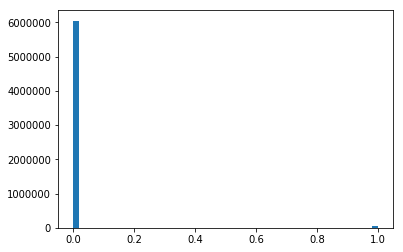

In [108]:
plt.hist(_[...,0].flatten(),50)

(array([6.042542e+06, 6.055000e+03, 3.000000e+03, 2.129000e+03,
        1.675000e+03, 1.699000e+03, 6.960000e+02, 6.550000e+02,
        9.620000e+02, 6.950000e+02, 1.188000e+03, 3.520000e+02,
        3.670000e+02, 7.000000e+02, 3.770000e+02, 5.120000e+02,
        3.460000e+02, 8.810000e+02, 2.190000e+02, 2.720000e+02,
        2.840000e+02, 6.190000e+02, 3.410000e+02, 3.590000e+02,
        2.610000e+02, 9.110000e+02, 2.070000e+02, 2.490000e+02,
        2.320000e+02, 6.400000e+02, 2.510000e+02, 3.470000e+02,
        3.080000e+02, 8.780000e+02, 2.480000e+02, 2.040000e+02,
        2.900000e+02, 6.320000e+02, 4.390000e+02, 4.190000e+02,
        7.660000e+02, 3.320000e+02, 7.020000e+02, 5.640000e+02,
        1.085000e+03, 9.560000e+02, 1.460000e+03, 1.230000e+03,
        2.620000e+03, 6.084400e+04]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.

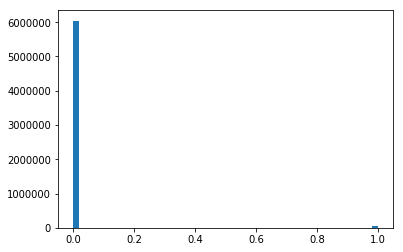

In [109]:
plt.hist(_[...,1].flatten(),50)

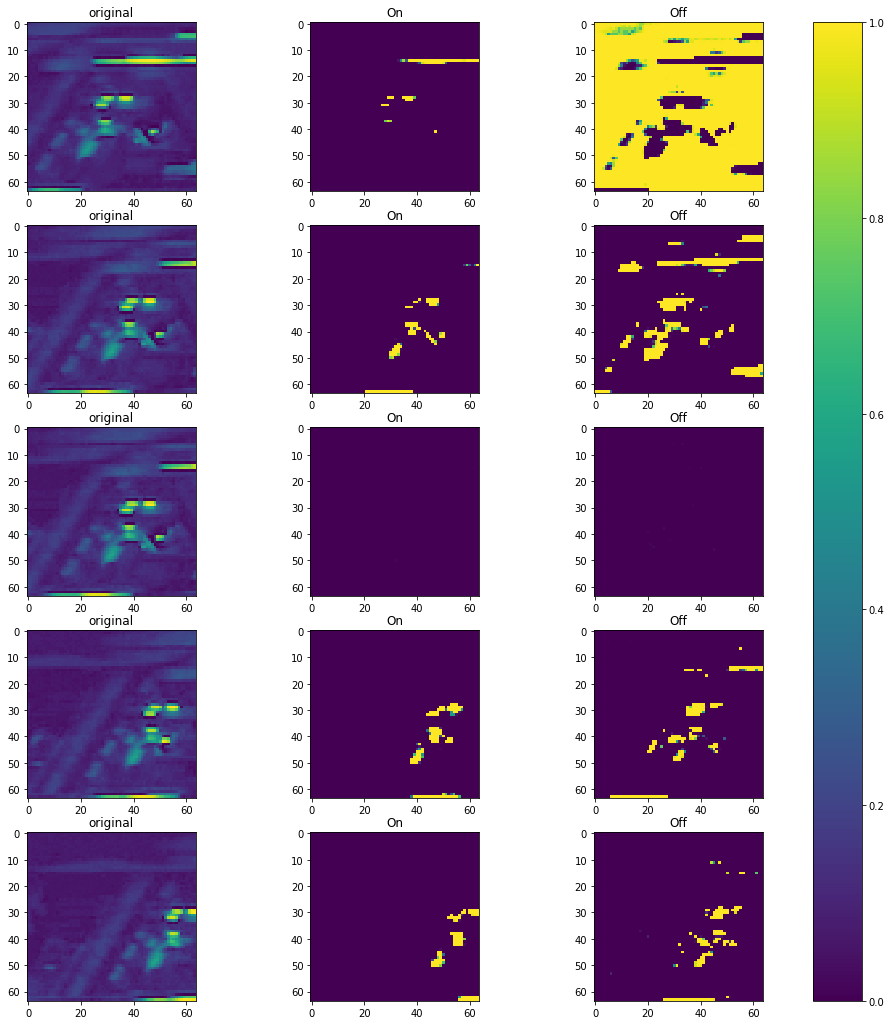

In [110]:
fig, ax = plt.subplots(5,3,figsize=(18,18))
for i in range(5):
    ax[i,0].imshow(X_val[0][0,i,:,:,0])
    ax[i,0].set_title('original')
    ax[i,1].imshow(_[0,i,:,:,0],vmin=0,vmax=1)
    ax[i,1].set_title('On')
    im=ax[i,2].imshow(_[0,i,:,:,1],vmin=0,vmax=1)
    ax[i,2].set_title('Off')
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

(2, 64, 64, 1)


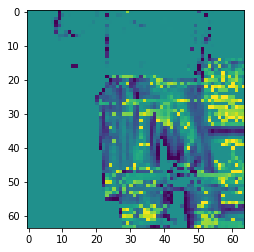

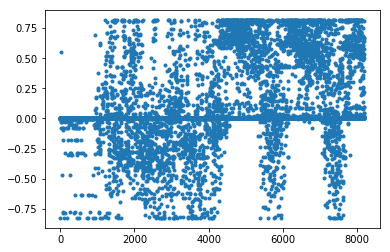

In [114]:
tmp=DVS_state.eval(feed,session=sess)
print(tmp.shape)
plt.imshow(tmp[0,:,:,0])
plt.show()
plt.plot(tmp.flatten(),'.')

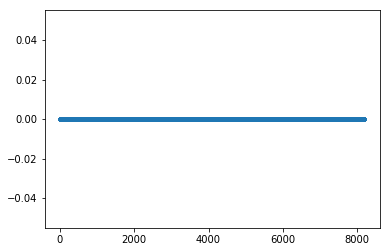

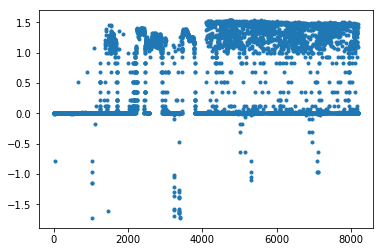

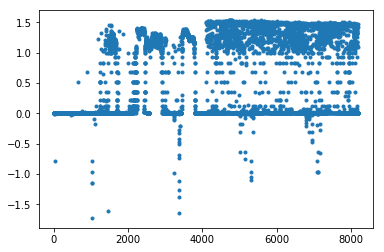

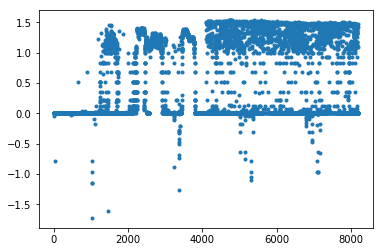

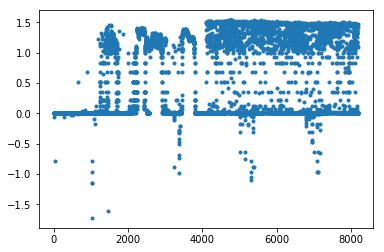

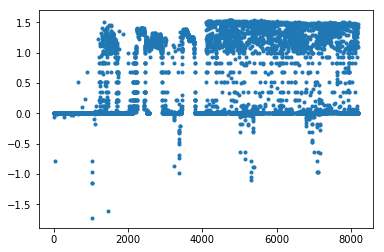

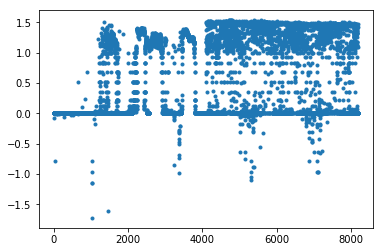

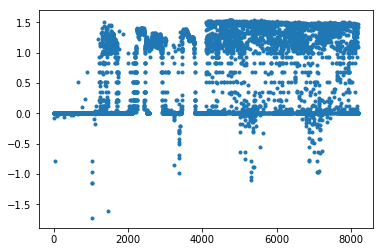

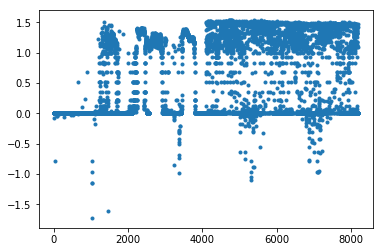

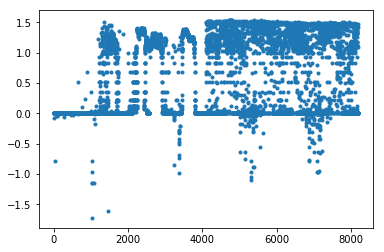

In [115]:
for i in range(10):
    tmp=state_track[i].eval(feed,session=sess)
    plt.plot(tmp.flatten(),'.')
    plt.show()

In [116]:
tmp.shape

(2, 64, 64, 1)

### just the differences between frames

In [ ]:
#TF MODEL:
#close previous session
sess.close()
#clean checkpoints
files = os.listdir('./running/other/')
for file in files:
    if file.startswith("runn"):
        os.remove('./running/other/'+file)
    if file.startswith("0train"):
        os.remove('./running/other/'+file)

graph = tf.Graph()#new tf graph
with graph.as_default():#use it as default
    
    #Batch Normalization - see below, channels last: NHWC for BN
    model_istrain = tf.placeholder(tf.bool)
    model_X=[]
    model_Y=[]
    model_Y_=[]
    model_kernels=[]
    model_masks=[]
    model_weights=[]
    model_MSE_neuron=[]
    model_MSE, model_reg_mask, model_reg_weights = 0, 0, 0
    
    for s in range(S):#i, x in enumerate(inputs_per_scan):
        with tf.variable_scope('net', reuse=(s > 0)):

            #input tensor of shape BDHWC - (batches, depth, height, width, channels)
            model_X.append(tf.placeholder(tf.float32,shape=[None,None,stim_x,stim_y,1]))
            #output: neurons x depth x batch
            model_Y.append(tf.placeholder(tf.float32,shape=[num_roi[s],None,None]))
            
            #DVS conv layer
            dvs_thresholds = tf.get_variable(name='dvs_thresh',
                                             shape=2,
                                             initializer=tf.constant_initializer([.1,.1]))
            dvs_thresholds = tf.abs(dvs_thresholds)
            
            model_DVS_diff = tf.nn.conv3d(model_X[-1],
                                          tf.constant([-1,1]),
                                          strides=[1,1,1,1,1],
                                          padding="VALID")
            
            first_image = tf.zeros_like(model_DVS_diff)[:,0,:,:,:]
            model_DVS_diff = tf.stack([first_image,model_DVS_diff],1)
            
            dvs_cond_p = tf.greater(model_DVS_diff, dvs_thresholds[0])
            dvs_cond_n = tf.smaller(model_DVS_diff, -dvs_thresholds[1])
            model_DVS = tf.where(dvs_cond_p,tf.ones_like(model_DVS_diff),tf.zeros_like(model_DVS_diff))
            model_DVS += tf.where(dvs_cond_n,-tf.ones_like(model_DVS_diff),tf.zeros_like(model_DVS_diff))

            #Conv layer 1
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            #model_kernels = []
            kernels = tf.get_variable(name='kernels1',
                                      shape=[ks[0,0],ks[0,1],ks[0,2],1,num_feat[0]],
                                      initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv1 = tf.nn.conv3d(model_X[-1],
                                    model_kernels[0],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv1 = tf.contrib.layers.batch_norm(model_conv1, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv1 = tf.nn.relu(model_conv1)

            #Conv layer 2
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels2',
                                            shape=[ks[1,0],ks[1,1],ks[1,2],num_feat[0],num_feat[1]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv2 = tf.nn.conv3d(model_conv1,
                                    model_kernels[1],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv2 = tf.contrib.layers.batch_norm(model_conv2, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv2 = tf.nn.relu(model_conv2)

            #Conv layer 3
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels3',
                                            shape=[ks[2,0],ks[2,1],ks[2,2],num_feat[1],num_feat[2]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv3 = tf.nn.conv3d(model_conv2,
                                    model_kernels[2],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv3 = tf.contrib.layers.batch_norm(model_conv3, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            #model_conv3 = tf.nn.relu(model_conv3)

            #shape now: BDHWC
            model_conv_out = tf.transpose(model_conv3,perm=[0,1,4,2,3])
            #shape now: BDCHW

            ## RF layers

        with tf.variable_scope('net', reuse=False):
            #mask: HWN
            model_masks.append(tf.get_variable(
                            name='masks{}'.format(s),
                            shape=sta_init[s].shape,
                            initializer=tf.constant_initializer(sta_init[s])))
            model_masks[-1] = tf.abs(model_masks[-1]) / (
                1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_masks[-1]),[0,1],keep_dims=True)))

            model_masked = tf.einsum('bdchw,hwn->bdcn',
                                 model_conv_out,
                                 model_masks[-1])#batch x depth x features x neurons
            
            #weighing
            model_weights_init = np.random.normal(1/num_feat[-1],.01,[num_feat[-1],num_roi[s]])
            model_weights.append(tf.get_variable(name='weights{}'.format(s),
                                            shape=[num_feat[-1],num_roi[s]],
                                            initializer=tf.constant_initializer(model_weights_init)))
            model_weights_a = tf.abs(model_weights[-1])# / (
            #    1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_weights), 0, keep_dims=True))))
            model_Y_.append(tf.transpose(tf.einsum('bdcn,cn->bdn',
                                 model_masked,
                                 model_weights_a),perm=[2,1,0]))

            model_MSE_neuron.append(tf.reduce_mean(tf.square(model_Y_[-1]-model_Y[-1]), [1, 2]))
            model_MSE += tf.reduce_sum(model_MSE_neuron[-1])

            model_reg_mask += .1 * tf.reduce_sum(tf.abs(model_masks[-1]))
            model_reg_weights += .001 * tf.reduce_sum(model_weights_a,1)
    
    #extra reg
    _,dum = tf.nn.moments(model_kernels[0]/(1e-8+tf.sqrt(tf.reduce_sum(
                    tf.square(model_kernels[0]),[0],keep_dims=True))),axes=[0])
    time_reg = .01*tf.reduce_sum(dum)
    #laplace smoothness
    W=tf.squeeze(model_kernels[1])#HWIO
    lap = tf.constant([[0.25, 0.5, 0.25], [0.5, -3.0, 0.5], [0.25, 0.5, 0.25]])
    lap = tf.expand_dims(tf.expand_dims(lap, 2), 3)
    out_channels = W.get_shape().as_list()[2]
    W_lap = tf.nn.depthwise_conv2d(tf.transpose(W, perm=[3, 0, 1, 2]),
                                   tf.tile(lap, [1, 1, out_channels, 1]),
                                   strides=[1, 1, 1, 1], padding='SAME')
    penalty = tf.reduce_sum(tf.reduce_sum(tf.square(W_lap), [1, 2]) / (
        tf.transpose(tf.reduce_sum(tf.square(W), [0, 1]))))
    penalty1 = tf.identity(.0001 * penalty, name='penalty')
    #group sparsity
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(W), [0, 1])))
    penalty2 = tf.identity(.001 * penalty, name='penalty')
    #3rd layer
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(model_kernels[2]), [0,1,2])))
    penalty3 = tf.identity(.001 * penalty, name='penalty')
    
    #Loss
    model_loss = model_MSE + model_reg_mask + model_reg_weights + penalty1 + penalty2 + penalty3 + time_reg
    
    #training ops
    model_lr = tf.placeholder(tf.float32)
    model_training = tf.train.AdamOptimizer(model_lr).minimize(model_loss)
    #BN
    model_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    #Train
    #with tf.Session() as sess:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    tmp_train=[]
    tmp_val=[]
    tmp_run=[]
    tmp_losses=[[],[],[],[],[],[],[]]#mse,mask,weight,time,group1,group2,laplace
    tmp_mean_fev=[]
    j = 0#batch counter

    feed_val = {model_istrain: False,
                model_lr: init_lr}
    feed_test = {model_istrain: False,
                 model_lr: init_lr}
    for s in range(S):
        feed_val.update({model_X[s]: X_val[s]})
        feed_val.update({model_Y[s]: Y_val[s]})
        feed_test.update({model_X[s]: X_test[s]})
        feed_test.update({model_Y[s]: Y_test[s]})

    #for plotting:
    cmap = plt.cm.get_cmap('hsv')
    colors = np.vstack([cmap(np.arange(1,6)/30),cmap(np.arange(1,10)/15+.3)])

    #saving text output to log file
    with open("running/other/running.txt", "w") as log:
        print('# TF MODEL (on Natural Movie Data) \n', file=log)
        
    #early stoppig
    stop_a=0
    stop_b=0
    lr=init_lr

    for i in range(10000):
        feed={model_istrain: True,
              model_lr: lr}
        for s in range(S):
            feed.update({model_X[s]: X_train[j][s]})
            feed.update({model_Y[s]: Y_train[j][s]})
        j += 1
        if j==len(X_train):
            shift = np.random.randint(0,50)

            X_train,Y_train=prepare_inputs(chunk_size=50,
                                                   batch_chunks=batch_chunks,
                                                   steps_hist=steps_hist,
                                                   shift=shift)
            j = 0#batch counter
        
        #often
        if not(i%50):
            tmp_run.append(i)
            tmp_Y_ = []
            weights = [] 
            masks = []
            MSE = np.zeros(N)
            ind=0
            for s in range(S):
                tmp_Y_.append(model_Y_[s].eval(feed_val,session=sess))
                weights.append(model_weights[s].eval(session=sess))
                masks.append(model_masks[s].eval(session=sess))
                MSE[ind:ind+num_roi[s]] = model_MSE_neuron[s].eval(feed_test,session=sess)
                ind+=num_roi[s]
                
            weights = np.concatenate(weights,1)
            masks = np.concatenate(masks,2)
            
            tmp_train.append(model_MSE.eval(feed,session=sess))
            tmp_val.append(model_MSE.eval(feed_val,session=sess))

            #not shown
            tmp_losses[0].append(tmp_train[-1])
            tmp_losses[1].append(model_reg_mask.eval(feed,session=sess))
            tmp_losses[2].append(model_reg_weights.eval(feed,session=sess))
            tmp_losses[3].append(time_reg.eval(feed,session=sess))
            tmp_losses[4].append(penalty2.eval(feed,session=sess))
            tmp_losses[5].append(penalty3.eval(feed,session=sess))
            tmp_losses[6].append(penalty1.eval(feed,session=sess))

            FEV= 1-(MSE.flatten()-observation_noise)/(signal_noise-observation_noise)
            tmp_mean_fev.append(np.mean(FEV))

            tmp_time=model_kernels[0].eval(session=sess)

            tmp_space=model_kernels[1].eval(session=sess)

            tmp_kernel2 = model_kernels[2].eval(session=sess)
            
            
            with open("running/other/running.txt", "a") as log:
                print('RUN = %s, MSE: train=%s, val=%s'%(
                    tmp_run[-1],tmp_train[-1],tmp_val[-1]), file=log)
            
            #Plotting!
            visualize(tmp_run,save=True,show=False,
                      mse=[tmp_train,tmp_val],
                      weights=[weights,num_roi,[True,True],num_roi],
                      pred_true=[np.concatenate(Y_val,0),np.concatenate(tmp_Y_,0)],
                      losses=[tmp_losses,['mse','mask','weight','time','group1','group2','laplace']],
                      mask=[masks],
                      fev=[FEV,tmp_mean_fev,num_roi],
                      time=[tmp_time],
                      space=[tmp_space],
                      kernel2=[tmp_kernel2])
            
            #early stopping?
            if tmp_val[-1]>np.min(tmp_val):#worse than best?
                stop_a += 1
                if stop_a==10:# times in a row worse
                    stop_b += 1
                    stop_a = 0
                    lr *= .9#lower lr
                    with open("running/other/absrunning.txt", "a") as log:
                        print('LR=%s'%(lr), file=log)
                    if stop_b==5:#lower lr x times
                        break
            else:
                stop_a=0

        sess.run([model_training,model_update_ops],feed)
#sess.close()

# Model DVS jittered

# Get jittered Movies

In [ ]:
#! load movies
Test = Image.open('test.tiff')
Test.load()
N = Test.n_frames
print('test frames = ',N,5*150)
X_nm_test = np.zeros([N,64,64])
i=0
for frame in ImageSequence.Iterator(Test):
    X_nm_test[i,:,:] = np.array(frame)
    i+=1
    
Train = Image.open('train.tiff')
Train.load()
N = Train.n_frames
print('train frames = ',N,108*150)
X_nm_train = np.zeros([N,64,64])
i=0
for frame in ImageSequence.Iterator(Train):
    X_nm_train[i,:,:] = np.array(frame)
    i+=1

In [ ]:
#! normalize all together (same transform on test and train):
mean = np.mean(np.concatenate((X_nm_test.flatten(),X_nm_train.flatten())))
X_nm_test -= mean
X_nm_train -= mean
std = np.std(np.concatenate((X_nm_test.flatten(),X_nm_train.flatten())))
X_nm_test /= std
X_nm_train /= std

In [ ]:
#get data...

In [ ]:
#TF MODEL:
#close previous session
sess.close()
#clean checkpoints
files = os.listdir('./running/other/')
for file in files:
    if file.startswith("runn"):
        os.remove('./running/other/'+file)
    if file.startswith("0train"):
        os.remove('./running/other/'+file)

graph = tf.Graph()#new tf graph
with graph.as_default():#use it as default
    
    #Batch Normalization - see below, channels last: NHWC for BN
    model_istrain = tf.placeholder(tf.bool)
    model_X=[]
    model_Y=[]
    model_Y_=[]
    model_kernels=[]
    model_masks=[]
    model_weights=[]
    model_MSE_neuron=[]
    model_MSE, model_reg_mask, model_reg_weights = 0, 0, 0
    
    for s in range(S):#i, x in enumerate(inputs_per_scan):
        with tf.variable_scope('net', reuse=(s > 0)):

            #input tensor of shape BDHWC - (batches, depth, height, width, channels)
            model_X.append(tf.placeholder(tf.float32,shape=[None,None,stim_x,stim_y,1]))
            #output: neurons x depth x batch
            model_Y.append(tf.placeholder(tf.float32,shape=[num_roi[s],None,None]))
            
            #DVS conv layer
            dvs_thresholds = tf.get_variable(name='dvs_thresh',
                                             shape=2,
                                             initializer=tf.constant_initializer([.1,.1]))
            dvs_thresholds = tf.abs(dvs_thresholds)
            
            model_DVS_diff = tf.nn.conv3d(model_X[-1],
                                          tf.constant([-1,1]),
                                          strides=[1,1,1,1,1],
                                          padding="VALID")
            
            first_image = tf.zeros_like(model_DVS_diff)[:,0,:,:,:]
            model_DVS_diff = tf.stack([first_image,model_DVS_diff],1)
            
            dvs_cond_p = tf.greater(model_DVS_diff, dvs_thresholds[0])
            dvs_cond_n = tf.smaller(model_DVS_diff, -dvs_thresholds[1])
            model_DVS = tf.where(dvs_cond_p,tf.ones_like(model_DVS_diff),tf.zeros_like(model_DVS_diff))
            model_DVS += tf.where(dvs_cond_n,-tf.ones_like(model_DVS_diff),tf.zeros_like(model_DVS_diff))
            
            #DVS temporal and spatial downsampling
            DVS_kernel = tf.get_variable(name='dvs_kernels',
                                      shape=[7,7,10,1,8],
                                      initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            model_DVS_conv = tf.nn.conv3d(model_DVS,
                                    DVS_kernel,
                                    strides=[1,1,10,1,1],
                                    padding="VALID")
            model_DVS_conv = tf.nn.relu(model_DVS_conv)
            

            #Conv layer 1
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            #model_kernels = []
            kernels = tf.get_variable(name='kernels1',
                                      shape=[ks[0,0],ks[0,1],ks[0,2],8,num_feat[0]],
                                      initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv1 = tf.nn.conv3d(model_DVS_conv,
                                    model_kernels[0],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv1 = tf.contrib.layers.batch_norm(model_conv1, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv1 = tf.nn.relu(model_conv1)

            #Conv layer 2
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels2',
                                            shape=[ks[1,0],ks[1,1],ks[1,2],num_feat[0],num_feat[1]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv2 = tf.nn.conv3d(model_conv1,
                                    model_kernels[1],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv2 = tf.contrib.layers.batch_norm(model_conv2, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            model_conv2 = tf.nn.relu(model_conv2)

            #Conv layer 3
            #filter: [filter_depth, filter_height, filter_width, in_channels, out_channels]
            kernels = tf.get_variable(name='kernels3',
                                            shape=[ks[2,0],ks[2,1],ks[2,2],num_feat[1],num_feat[2]],
                                            initializer=tf.random_normal_initializer(mean=0,stddev=.03))
            if not s:
                model_kernels.append(kernels)
            model_conv3 = tf.nn.conv3d(model_conv2,
                                    model_kernels[2],
                                    strides=[1,1,1,1,1],
                                    padding="VALID")# BDHWC
            #model_conv3 = tf.contrib.layers.batch_norm(model_conv3, center=False, scale=True,
            #                    is_training=model_istrain,variables_collections=['batch_norm_ema'],
            #                                             decay=.98)
            #model_conv3 = tf.nn.relu(model_conv3)

            #shape now: BDHWC
            model_conv_out = tf.transpose(model_conv3,perm=[0,1,4,2,3])
            #shape now: BDCHW

            ## RF layers

        with tf.variable_scope('net', reuse=False):
            #mask: HWN
            model_masks.append(tf.get_variable(
                            name='masks{}'.format(s),
                            shape=sta_init[s].shape,
                            initializer=tf.constant_initializer(sta_init[s])))
            model_masks[-1] = tf.abs(model_masks[-1]) / (
                1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_masks[-1]),[0,1],keep_dims=True)))

            model_masked = tf.einsum('bdchw,hwn->bdcn',
                                 model_conv_out,
                                 model_masks[-1])#batch x depth x features x neurons
            
            #weighing
            model_weights_init = np.random.normal(1/num_feat[-1],.01,[num_feat[-1],num_roi[s]])
            model_weights.append(tf.get_variable(name='weights{}'.format(s),
                                            shape=[num_feat[-1],num_roi[s]],
                                            initializer=tf.constant_initializer(model_weights_init)))
            model_weights_a = tf.abs(model_weights[-1])# / (
            #    1e-5 + tf.sqrt(tf.reduce_sum(tf.square(model_weights), 0, keep_dims=True))))
            model_Y_.append(tf.transpose(tf.einsum('bdcn,cn->bdn',
                                 model_masked,
                                 model_weights_a),perm=[2,1,0]))

            model_MSE_neuron.append(tf.reduce_mean(tf.square(model_Y_[-1]-model_Y[-1]), [1, 2]))
            model_MSE += tf.reduce_sum(model_MSE_neuron[-1])

            model_reg_mask += .1 * tf.reduce_sum(tf.abs(model_masks[-1]))
            model_reg_weights += .001 * tf.reduce_sum(model_weights_a,1)
    
    #extra reg
    _,dum = tf.nn.moments(model_kernels[0]/(1e-8+tf.sqrt(tf.reduce_sum(
                    tf.square(model_kernels[0]),[0],keep_dims=True))),axes=[0])
    time_reg = .01*tf.reduce_sum(dum)
    #laplace smoothness
    W=tf.squeeze(model_kernels[1])#HWIO
    lap = tf.constant([[0.25, 0.5, 0.25], [0.5, -3.0, 0.5], [0.25, 0.5, 0.25]])
    lap = tf.expand_dims(tf.expand_dims(lap, 2), 3)
    out_channels = W.get_shape().as_list()[2]
    W_lap = tf.nn.depthwise_conv2d(tf.transpose(W, perm=[3, 0, 1, 2]),
                                   tf.tile(lap, [1, 1, out_channels, 1]),
                                   strides=[1, 1, 1, 1], padding='SAME')
    penalty = tf.reduce_sum(tf.reduce_sum(tf.square(W_lap), [1, 2]) / (
        tf.transpose(tf.reduce_sum(tf.square(W), [0, 1]))))
    penalty1 = tf.identity(.0001 * penalty, name='penalty')
    #group sparsity
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(W), [0, 1])))
    penalty2 = tf.identity(.001 * penalty, name='penalty')
    #3rd layer
    penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(model_kernels[2]), [0,1,2])))
    penalty3 = tf.identity(.001 * penalty, name='penalty')
    
    #Loss
    model_loss = model_MSE + model_reg_mask + model_reg_weights + penalty1 + penalty2 + penalty3 + time_reg
    
    #training ops
    model_lr = tf.placeholder(tf.float32)
    model_training = tf.train.AdamOptimizer(model_lr).minimize(model_loss)
    #BN
    model_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    #Train
    #with tf.Session() as sess:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    tmp_train=[]
    tmp_val=[]
    tmp_run=[]
    tmp_losses=[[],[],[],[],[],[],[]]#mse,mask,weight,time,group1,group2,laplace
    tmp_mean_fev=[]
    j = 0#batch counter

    feed_val = {model_istrain: False,
                model_lr: init_lr}
    feed_test = {model_istrain: False,
                 model_lr: init_lr}
    for s in range(S):
        feed_val.update({model_X[s]: X_val[s]})
        feed_val.update({model_Y[s]: Y_val[s]})
        feed_test.update({model_X[s]: X_test[s]})
        feed_test.update({model_Y[s]: Y_test[s]})

    #for plotting:
    cmap = plt.cm.get_cmap('hsv')
    colors = np.vstack([cmap(np.arange(1,6)/30),cmap(np.arange(1,10)/15+.3)])

    #saving text output to log file
    with open("running/other/running.txt", "w") as log:
        print('# TF MODEL (on Natural Movie Data) \n', file=log)
        
    #early stoppig
    stop_a=0
    stop_b=0
    lr=init_lr

    for i in range(10000):
        feed={model_istrain: True,
              model_lr: lr}
        for s in range(S):
            feed.update({model_X[s]: X_train[j][s]})
            feed.update({model_Y[s]: Y_train[j][s]})
        j += 1
        if j==len(X_train):
            shift = np.random.randint(0,50)

            X_train,Y_train=prepare_inputs(chunk_size=50,
                                                   batch_chunks=batch_chunks,
                                                   steps_hist=steps_hist,
                                                   shift=shift)
            j = 0#batch counter
        
        #often
        if not(i%50):
            tmp_run.append(i)
            tmp_Y_ = []
            weights = [] 
            masks = []
            MSE = np.zeros(N)
            ind=0
            for s in range(S):
                tmp_Y_.append(model_Y_[s].eval(feed_val,session=sess))
                weights.append(model_weights[s].eval(session=sess))
                masks.append(model_masks[s].eval(session=sess))
                MSE[ind:ind+num_roi[s]] = model_MSE_neuron[s].eval(feed_test,session=sess)
                ind+=num_roi[s]
                
            weights = np.concatenate(weights,1)
            masks = np.concatenate(masks,2)
            
            tmp_train.append(model_MSE.eval(feed,session=sess))
            tmp_val.append(model_MSE.eval(feed_val,session=sess))

            #not shown
            tmp_losses[0].append(tmp_train[-1])
            tmp_losses[1].append(model_reg_mask.eval(feed,session=sess))
            tmp_losses[2].append(model_reg_weights.eval(feed,session=sess))
            tmp_losses[3].append(time_reg.eval(feed,session=sess))
            tmp_losses[4].append(penalty2.eval(feed,session=sess))
            tmp_losses[5].append(penalty3.eval(feed,session=sess))
            tmp_losses[6].append(penalty1.eval(feed,session=sess))

            FEV= 1-(MSE.flatten()-observation_noise)/(signal_noise-observation_noise)
            tmp_mean_fev.append(np.mean(FEV))

            tmp_time=model_kernels[0].eval(session=sess)

            tmp_space=model_kernels[1].eval(session=sess)

            tmp_kernel2 = model_kernels[2].eval(session=sess)
            
            
            with open("running/other/running.txt", "a") as log:
                print('RUN = %s, MSE: train=%s, val=%s'%(
                    tmp_run[-1],tmp_train[-1],tmp_val[-1]), file=log)
            
            #Plotting!
            visualize(tmp_run,save=True,show=False,
                      mse=[tmp_train,tmp_val],
                      weights=[weights,num_roi,[True,True],num_roi],
                      pred_true=[np.concatenate(Y_val,0),np.concatenate(tmp_Y_,0)],
                      losses=[tmp_losses,['mse','mask','weight','time','group1','group2','laplace']],
                      mask=[masks],
                      fev=[FEV,tmp_mean_fev,num_roi],
                      time=[tmp_time],
                      space=[tmp_space],
                      kernel2=[tmp_kernel2])
            
            #early stopping?
            if tmp_val[-1]>np.min(tmp_val):#worse than best?
                stop_a += 1
                if stop_a==10:# times in a row worse
                    stop_b += 1
                    stop_a = 0
                    lr *= .9#lower lr
                    with open("running/other/absrunning.txt", "a") as log:
                        print('LR=%s'%(lr), file=log)
                    if stop_b==5:#lower lr x times
                        break
            else:
                stop_a=0

        sess.run([model_training,model_update_ops],feed)
#sess.close()